### Imports

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('wordnet')

import string
import re
import numpy as np
import pandas as pd
import os
from tabulate import tabulate #for pretty printing of df

import gensim
from gensim.models.phrases import Phrases, Phraser

import itertools  #used for flattening lists of lists
import math
import csv
from help_functions import test_dictionary #for quickly pretty dictionary
from help_functions import get_next_qtr #for getting next quarter given a quarter/year
import matplotlib.pyplot as plt
from collections import Counter
import time



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Stop Words, CSV Files, and Year List, SNL_Map

In [2]:
nltk_stop_words = set(stopwords.words('english'))
words_to_remove = ['below', 'haven']   #reasonable words to be meaningful
stop_words = list(filter(lambda word: word not in words_to_remove, nltk_stop_words))
print(f'stop_words: {stop_words}')

### create list of csv files and years
csv_files = [os.path.join('data', file) for file in os.listdir('data')]
years_list = list(range(2009, 2025))

### create a look up file to get ciq id and map to related snl id
seed_words = ['uncertainty','uncertain','ambiguity', 'confusion', 'unpredictable', 'unpredictability']

### import csv as dataframes for transcript/company ids and loan data/snl ids
delta_df = pd.read_csv('snldata/transcript_loans.csv', encoding='utf-8')
print()
print(tabulate(delta_df.head(), headers='keys', tablefmt='pretty'))

print('')
print(f'mapping files have been loaded in')

stop_words: ['was', "weren't", 'down', 'they', 'aren', 'mightn', 'nor', 'what', 'that', "hasn't", "wasn't", "you're", 'during', 'is', 'won', 'only', 'to', 'themselves', 'having', "you'll", 'been', 'we', 'll', 'at', 'on', 'after', "mustn't", "couldn't", 'hasn', 'will', 'no', 'itself', 't', 'i', 'she', 'did', 'ourselves', 'here', 'if', 'its', 'himself', "aren't", 'than', 'between', 'his', 'other', 'wouldn', 'their', 'theirs', 'ours', 'does', 'until', 'isn', 'by', 'an', 'yourself', 'into', "should've", 'hers', 'and', 'while', 'off', "mightn't", 'me', "she's", "that'll", 'or', 'from', 'y', 'with', 'can', 'should', 'hadn', "needn't", 'how', 'when', 'couldn', 'against', 'so', 'up', 'd', 'my', 'he', "shouldn't", 'ain', 'now', 'any', 'each', 'it', 'own', 'herself', 'once', "it's", 'yourselves', 'have', 'do', 'not', 'under', 've', "wouldn't", 'about', 'few', 'her', 'm', 'o', 'our', "haven't", 'your', 'shouldn', 'don', 'being', 'him', 'same', 's', 'you', 'needn', "won't", 'above', 'in', 'more', 

In [3]:
with open('snldata/soto_uncertainty_words.txt', 'r') as file:
    # Read each line and strip the newline characters
    soto_uncertainty_words = [line.strip() for line in file.readlines()]

print(f'soto uncertainty words: {soto_uncertainty_words}')

soto uncertainty words: ['adapted', 'amid', 'amidst', 'amplified', 'anxiety', 'attacks', 'austerity', 'backdrop', 'benign', 'bipartisan', 'brexit', 'ceiling', 'challenges', 'challenging', 'cliff', 'climate', 'clouded', 'commonwealth', 'concerns', 'conditions', 'confluence', 'confronting', 'congress', 'consumption', 'crash', 'crises', 'currents', 'cycles', 'deficit', 'deficits', 'deflation', 'deflationary', 'downturn', 'dysfunction', 'economic', 'election', 'elections', 'emerged', 'encountered', 'environment', 'environments', 'eu', 'euro', 'eurozone', 'face', 'faced', 'faces', 'facing', 'fears', 'fiscal', 'flash', 'fragile', 'franc', 'geo', 'geopolitical', 'governmental', 'governments', 'gridlock', 'gyrations', 'hampering', 'headwinds', 'heightened', 'illiquidity', 'immune', 'impasse', 'instability', 'intervention', 'iraq', 'lackluster', 'legislative', 'legislature', 'lingering', 'looming', 'ltro', 'macroeconomic', 'makers', 'midst', 'midterm', 'monetary', 'myriad', 'nafta', 'navigate',

## Class Definition for Object Storage

In [4]:
#create objects to store data for each year and all years combined


class Nodes:
  node_dict = {} #tracks nodes for each year

  def __init__(self, year, corpus_bigrams, bigram_dict, flat_corpus_bigrams, model=None, uncertainty_wordlist=None):

    self.year = year
    self.model = model
    self.uncertainty_wordlist = uncertainty_wordlist  #tracks final uncertainty wordlist
    self.corpus_bigrams = corpus_bigrams              #stores the cleaned corpus with bigrams for running model (list of sentences)
    self.bigram_dict = bigram_dict                    #dictionary storing transcript_id:list of sentences for scoring
    self.flat_corpus_bigrams = flat_corpus_bigrams    #stores flattened list of corpus bigrams for idf calculation

    Nodes.node_dict[year] = self

#tracks combined node
class Combined_Node:

  def __init__(self, corpus_bigrams, bigram_dict, flat_corpus_bigrams, model=None, uncertainty_wordlist=None):

    self.model = model
    self.uncertainty_wordlist = uncertainty_wordlist
    self.corpus_bigrams = corpus_bigrams
    self.bigram_dict = bigram_dict
    self.flat_corpus_bigrams = flat_corpus_bigrams



## Functions

### Split Text Function

In [5]:
#take raw text and tokenize the words
def split_text_to_sentences_words(text):
    # Split into sentences
    sentences = nltk.sent_tokenize(text)

    # Split each sentence into a list of words
    sentences_words = [nltk.word_tokenize(sentence) for sentence in sentences]

    return sentences_words

#grab pos for lemmatizing
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to NOUN

### Get Corpus

In [6]:
#takes single csv file and returns dictionary transcipt_id: [[word, word, word],[word, word, word]]
def get_corpus(csv_file):
   df = pd.read_csv(csv_file, encoding='utf-8')
   df['COMPONENTTEXT_SPLIT'] = df['COMPONENTTEXT'].apply(split_text_to_sentences_words) #splits data in pandas cell into list of sentences

   unprocessed_dict = {}
   for row in df.itertuples():
      if row.TRANSCRIPTID not in unprocessed_dict:
         unprocessed_dict[row.TRANSCRIPTID] = row.COMPONENTTEXT_SPLIT
      else:
         unprocessed_dict[row.TRANSCRIPTID].extend(row.COMPONENTTEXT_SPLIT)
   return unprocessed_dict


### Process Dict

In [7]:
#takes unprocessed dict and returns processed dict (lowercase, lemmatize with pos, remove punct, leave hyphens)
def process_the_data_lemmatizer(unprocessed_dict, stop_words):
   num_tokens_before = 0
   num_tokens_after = 0
   processed_dict = {}

   lemmatizer = WordNetLemmatizer()

   for transcriptid, text in unprocessed_dict.items():
      p_text = []
      for sentence in text:
         p_sentence = []
         for word in sentence:
            num_tokens_before += 1
            p_word = word.lower()                                  #lowercase the text
            p_word = re.sub(r'(?<!\w)-(?!\w)|[^\w\s-]', '', p_word)
            p_sentence.append(p_word)  #remove punctuation but keep hyphens

         lemmatized_sentence = [lemmatizer.lemmatize(word, get_wordnet_pos(word))
                                 for word in p_sentence if word not in stop_words and len(word) > 0]

         p_text.append(lemmatized_sentence)
         num_tokens_after += len(lemmatized_sentence)
      processed_dict[transcriptid] = p_text
   return processed_dict


#below does not use lemmatizer. much faster.
def process_the_data(unprocessed_dict, stop_words):
   num_tokens_before = 0
   num_tokens_after = 0
   processed_dict = {}

   for transcriptid, text in unprocessed_dict.items():
      p_text = []
      for sentence in text:
         p_sentence = []
         for word in sentence:
            num_tokens_before += 1
            p_word = word.lower()                                  #lowercase the text
            p_word = re.sub(r'(?<!\w)-(?!\w)|[^\w\s-]', '', p_word)  #remove punctuation but keep hyphens
            if p_word in stop_words or len(p_word) == 0:             #ignore if word has no length (ie was punctuation only) or in stop words
               continue
            p_sentence.append(p_word)
         p_text.append(p_sentence)
         num_tokens_after += len(p_sentence)
      processed_dict[transcriptid] = p_text
   print(f'tokens before:{num_tokens_before} | tokens after:{num_tokens_after}')
   return processed_dict



### Create Bigrams

In [8]:
"""
below function returns:
    corpus_bigrams: list of sentences for full corpus to run through word2vec
    dict_bigrams: links transcript id to corpus for uncertainty calc
    flat_corpus_bigrams: flat version of corpus bigrams for counting word appearances easily
"""

def create_bigrams(processed_dict, min_count=10, threshold = 100):
   processed_corpus = [['']]
   for value in processed_dict.values():
      processed_corpus.extend(value)

   phrases = Phrases(processed_corpus, min_count, threshold, scoring='default')
   bigram_phraser = Phraser(phrases)

   corpus_bigrams = [['']]

   dict_bigrams = {}
   for transcript_id, text in processed_dict.items():
      bigram_text = [bigram_phraser[sentence] for sentence in text]
      dict_bigrams[transcript_id] = bigram_text
      corpus_bigrams.extend(bigram_text)


   flat_corpus_bigrams = [item for sublist in corpus_bigrams for item in sublist]  #flatten list

   # print('bigrams created')
   return phrases, bigram_phraser, corpus_bigrams, dict_bigrams, flat_corpus_bigrams


### Create IDF dictionary

In [9]:
#create idf dictionary upon node creation by looking at uncertainty word list
def create_idf_dict(node):
    idf_dict = {}
    n = len(node.bigram_dict) #number of transcripts
    for word in node.uncertainty_wordlist:
        t = 0
        for transcript_id, bigrams in node.bigram_dict.items():
            transcript_text = list(itertools.chain.from_iterable(bigrams)) #flattens list easier boolean check
            if word in transcript_text:
                t+=1   #count if word appears in transcript

        idf= math.log2(n/t)
        idf_dict[word] = idf
    return idf_dict


#seperate run to create an idf dict for soto uncertainty words
def create_idf_dict_soto_wordlist(node, soto_uncertainty_words):
    idf_dict = {}
    n = len(node.bigram_dict)
    for word in soto_uncertainty_words:
        t = 1          #initialize at 1 so you don't divide by 0 if word never appears
        for transcript_id, bigrams in node.bigram_dict.items():
            transcript_text = list(itertools.chain.from_iterable(bigrams))
            if word in transcript_text:
                t+=1

        idf= math.log2(n/t)
        idf_dict[word] = idf

    return idf_dict



### Build uncertainty words

In [10]:
#uses a list of seed words and collects top n words by proximity score

def build_uncertainty_words(node, trained_model, seed_words, delta_df, return_number = 100):
    result_dictionary = {}
    for seed_word in seed_words:
        try:
            similar_words = trained_model.wv.most_similar(seed_word, topn=300)
        except KeyError:
            continue
        for word, number in similar_words:
            if word not in result_dictionary:
                result_dictionary[word] = number
            else:
                result_dictionary[word] = max(number, result_dictionary[word])

    ordered_words = sorted(result_dictionary, key=result_dictionary.get, reverse=True)     # orders word list by score
    final_list = []                                                                        # checks that the word appears in at least two different companies
    while len(final_list) < return_number:
        for word in ordered_words:
            # print(word)
            ciq_id_count = transcript_lookup(word, node.bigram_dict, delta_df)
            # print(ciq_id_count)
            if ciq_id_count < 2:
                continue
            else: final_list.append(word)
            if len(final_list) == return_number:
                break

    return final_list


### Calculate Uncertainty scores - regular and soto variant

In [11]:

#calculates uncertainty in a node by counting uncertainty words and dividing by bigram transcript length. Adds score to dataframe.
def calc_uncertainty_reg(node, delta_df, column_name):
    for transcript_id, bigrams in node.bigram_dict.items():
        transcript_text = list(itertools.chain.from_iterable(bigrams))
        uncty_cnt = 0
        for word in transcript_text:
            if word in node.uncertainty_wordlist:
                uncty_cnt += 1
        uncty_score = uncty_cnt/len(transcript_text)
        try:
            delta_df.loc[delta_df['transcript_id'] == transcript_id, column_name] = uncty_score
        except KeyError:
            continue

#calculates uncertainty in a node by counting uncertainty words if they appear, weighing by tf_idf, and dividing by number of words in transcript
def calc_uncertainty_soto(node, delta_df, column_name):
    for transcript_id, bigrams in node.bigram_dict.items():
        transcript_text = list(itertools.chain.from_iterable(bigrams))
        word_count_dict = Counter(transcript_text)    #creates a count dictionary for each word in transcript
        d = len(transcript_text)
        tf_idf_sum = 0
        for word in node.uncertainty_wordlist:
            if word in transcript_text:
                t = word_count_dict[word]
                tf = t/d
                idf = node.idf_dict[word]
                # print(f'word:{word}| t:{t}|d:{d}|tf:{tf}|idf:{idf}')
                tf_idf = tf*idf
                tf_idf_sum += tf_idf

        uncty_score = tf_idf_sum/len(set(transcript_text))
        # print(f'tf_idf_sum: {tf_idf_sum}| transcript length: {len(set(transcript_text))}|uncty_score:{uncty_score}')

        try:
            delta_df.loc[delta_df['transcript_id'] == transcript_id, column_name] = uncty_score #some transcripts missing if there wasn't any financial data
            # print(uncty_score)
        except KeyError:
            # print(f'{transcript_id}: key error')
            continue


#calculates soto uncertainty using soto method
def calc_uncertainty_soto_wordlist(node, delta_df, column_name, soto_uncertainty_words):
    for transcript_id, bigrams in node.bigram_dict.items():
        transcript_text = list(itertools.chain.from_iterable(bigrams))
        word_count_dict = Counter(transcript_text)
        d = len(transcript_text)
        tf_idf_sum = 0
        for word in soto_uncertainty_words:
            if word in transcript_text:
                t = word_count_dict[word]
                tf = t/d
                idf = node.idf_dict_full[word]
                # print(f'word:{word}| t:{t}|d:{d}|tf:{tf}|idf:{idf}')
                tf_idf = tf*idf
                tf_idf_sum += tf_idf

        uncty_score = tf_idf_sum/len(set(transcript_text))
        # print(f'tf_idf_sum: {tf_idf_sum}| transcript length: {len(set(transcript_text))}|uncty_score:{uncty_score}')

        try:
            delta_df.loc[delta_df['transcript_id'] == transcript_id, column_name] = uncty_score
            # print(uncty_score)
        except KeyError:
            # print(f'{transcript_id}: key error')
            continue



### Extend yearly corpus to full corpus

In [12]:
#helper functuon that takes each year and combines dictionaries to create one complete node
def extend_to_full(model_node_dict):
    corpus_bigrams_allyrs = []
    flat_corpus_allyrs = []
    bigram_dict_allyrs = {}

    for year, node in model_node_dict.items():
        corpus_bigrams_allyrs.extend(node.corpus_bigrams)
        flat_corpus_allyrs.extend(node.flat_corpus_bigrams)
        bigram_dict_allyrs.update(node.bigram_dict)

    return corpus_bigrams_allyrs,flat_corpus_allyrs,bigram_dict_allyrs


### Lookup word and year to see which which transcripts contain it

In [13]:
def company_quarter_lookup(transcript_id, delta_df):

    try:
        ciq_id = delta_df.loc[delta_df['transcript_id'] == transcript_id, 'ciq_id'].values[0]
        quarter = delta_df.loc[delta_df['transcript_id'] == transcript_id, 'quarter'].values[0]
    except IndexError:
        ciq_id = 11111
        quarter = 'NA'
    return(ciq_id,quarter)


def transcript_lookup(word, dict, delta_df):
    count_set = set()
    for transcript_id, bigrams in dict.items():
        flat_list = list(itertools.chain.from_iterable(bigrams))
        if word in flat_list:
            # print(word, transcript_id)
            ciq_id, quarter = company_quarter_lookup(transcript_id, delta_df)
            count_set.add(ciq_id)
        if len(count_set) == 2:
            break
    return len(count_set)


def transcript_lookup_print(word, dict, delta_df):
    for transcript_id, bigrams in dict.items():
        flat_list = list(itertools.chain.from_iterable(bigrams))
        count_set = set()
        if word in flat_list:
            ciq_id, quarter = company_quarter_lookup(transcript_id, delta_df)
            print(transcript_id, ciq_id, quarter)

### Word2Vec Model

In [14]:

def apply_word2vec(corpus_bigrams):
   model = gensim.models.Word2Vec (
    vector_size=300,    # Number of features in word vector

    window=10,   # Context window size (in each direction). Default is 5


    min_count=15, # Words must appear this many times to be in vocab.
                 #   Default is 5

    workers=10,  # Training thread count

    sg=1,        # 0: CBOW, 1: Skip-gram.

    hs=0,        # 0: Negative Sampling, 1: Hierarchical Softmax
                 #   Default is 0, NS

    negative=5   # Nmber of negative samples
                 #   Default is 5
   )

   model.build_vocab(
    corpus_bigrams,
    progress_per=20000  # Tweaks how often progress is reported
   )

   model.train(
    corpus_bigrams,
    total_examples=len(corpus_bigrams),
    epochs=20,        # How many training passes to take.
    report_delay=10.0 # Report progress every 10 seconds.
   )

   return(model)

## Run Models

### Process the data

In [15]:
#Process Data

for index, file in enumerate(csv_files):
    corpus_dict = get_corpus(file)
    processed_corpus_dict = process_the_data_lemmatizer (corpus_dict, stop_words)
    phrases, bigram_phraser, corpus_bigrams, bigram_dict, flat_corpus_bigrams = create_bigrams(processed_corpus_dict)

    Nodes(year=years_list[index], corpus_bigrams=corpus_bigrams, bigram_dict=bigram_dict, flat_corpus_bigrams = flat_corpus_bigrams)


corpus_bigrams_allyrs,flat_corpus_allyrs,bigram_dict_allyrs = extend_to_full(Nodes.node_dict)
full_node = Combined_Node(corpus_bigrams=corpus_bigrams_allyrs, bigram_dict = bigram_dict_allyrs, flat_corpus_bigrams = flat_corpus_allyrs)
print('done!!')

done!!


### Train the Models

In [16]:
#Train Models

#yearly corupus
for year, node in Nodes.node_dict.items():
    start_time = time.time()
    trained_model = apply_word2vec(node.corpus_bigrams)
    end_time = time.time()
    print(f"Time taken for processing {year}: {end_time - start_time:.4f} seconds")

    start_time = time.time()
    word_list = build_uncertainty_words( node,trained_model, seed_words, delta_df, 100)
    end_time = time.time()
    print(f"Time taken for model getting uncertainty words {year}: {end_time - start_time:.4f} seconds")




    node.model=trained_model
    node.uncertainty_wordlist=word_list

    start_time = time.time()
    idf_dict = create_idf_dict(node)
    end_time = time.time()
    print(f"Time taken for idf creation {year}: {end_time - start_time:.4f} seconds")

    node.idf_dict = idf_dict


#full corpus
# start_time = time.time()
# trained_model = apply_word2vec(full_node.corpus_bigrams)
# end_time = time.time()
# print(f"Time taken for full node model creation: {end_time - start_time:.4f} seconds")

# word_list = build_uncertainty_words(full_node, trained_model, seed_words, delta_df, 150)


# full_node.model=trained_model
# full_node.uncertainty_wordlist=word_list
# start_time = time.time()
# idf_dict = create_idf_dict(full_node)
# end_time = time.time()
# print(f"Time taken for full node idf creation {year}: {end_time - start_time:.4f} seconds")

# full_node.idf_dict = idf_dict



Time taken for processing 2009: 81.3296 seconds
Time taken for model getting uncertainty words 2009: 1.2663 seconds
Time taken for idf creation 2009: 8.0634 seconds
Time taken for processing 2010: 88.2128 seconds
Time taken for model getting uncertainty words 2010: 1.3019 seconds
Time taken for idf creation 2010: 7.3344 seconds
Time taken for processing 2011: 108.6383 seconds
Time taken for model getting uncertainty words 2011: 1.2666 seconds
Time taken for idf creation 2011: 9.2596 seconds
Time taken for processing 2012: 103.5485 seconds
Time taken for model getting uncertainty words 2012: 1.7514 seconds
Time taken for idf creation 2012: 9.3610 seconds
Time taken for processing 2013: 100.1137 seconds
Time taken for model getting uncertainty words 2013: 1.9010 seconds
Time taken for idf creation 2013: 9.1306 seconds
Time taken for processing 2014: 96.2350 seconds
Time taken for model getting uncertainty words 2014: 1.7943 seconds
Time taken for idf creation 2014: 8.7227 seconds
Time ta

In [17]:
start_time = time.time()
trained_model = apply_word2vec(full_node.corpus_bigrams)
end_time = time.time()
print(f"Time taken for full node model creation: {end_time - start_time:.4f} seconds")

start_time = time.time()
word_list = build_uncertainty_words(full_node, trained_model, seed_words, delta_df, 150)
end_time = time.time()
print(f"Time taken for to build uncertainty word list: {end_time - start_time:.4f} seconds")

full_node.model=trained_model
full_node.uncertainty_wordlist=word_list
start_time = time.time()
idf_dict = create_idf_dict(full_node)
end_time = time.time()
print(f"Time taken for full node idf creation {year}: {end_time - start_time:.4f} seconds")

full_node.idf_dict = idf_dict


Time taken for full node model creation: 1850.5355 seconds
Time taken for to build uncertainty word list: 39.9962 seconds
Time taken for full node idf creation 2024: 241.2918 seconds


### Count Bigrams and Tokens

In [37]:
bigram_count = 0
unique_bigrams = set()
unique_tokens = set()

# Loop through the list and check for underscores
for token in full_node.flat_corpus_bigrams:
    unique_tokens.add(token)
    if "_" in token:
        bigram_count += 1
        unique_bigrams.add(token)

print(f'Total Tokens: {len(full_node.flat_corpus_bigrams)}')
print(f'Unique Tokens: {len(unique_tokens)}')
print(f'Total Bigrams: {bigram_count}')
print(f'Unique Bigrams: {len(unique_bigrams)}')


Total Tokens: 28922914
Unique Tokens: 72821
Total Bigrams: 651021
Unique Bigrams: 2525


In [18]:


# idf_dict_full = create_idf_dict_soto_wordlist(full_node, soto_uncertainty_words)
# full_node.idf_dict_full = idf_dict_full

## Calc Uncertainty Scores

In [19]:
#recreates idf_dicts with up-to-date uncertainty wordlists

# for year, node in Nodes.node_dict.items():
#     idf_dict = create_idf_dict(node)
#     node.idf_dict = idf_dict

# full_node.idf_dict = create_idf_dict(full_node)

In [20]:
#calculate all the different uncertainty scores and add to dataframe

for year, node in Nodes.node_dict.items():
    calc_uncertainty_reg(node, delta_df, 'yearnode_uncty_reg')


calc_uncertainty_reg(full_node, delta_df, 'fullnode_uncty_reg')

for year, node in Nodes.node_dict.items():
    calc_uncertainty_soto(node, delta_df, 'yearnode_uncty_soto')


calc_uncertainty_soto(full_node, delta_df, 'fullnode_uncty_soto')

print(tabulate(delta_df.head(), headers='keys', tablefmt='pretty'))

# calc_uncertainty_soto_wordlist(full_node, delta_df, 'fullnode_uncty_soto_wl', soto_uncertainty_words)

+---+---------------+------------+-----------+---------+--------+--------------------+-------------------+-------------+------------+--------------+-----------+-----------------------+----------------------+------------------------+------------------------+
|   | transcript_id |   ciq_id   |  snl_id   | quarter |  year  | total_asset_before | total_asset_after | loan_before | loan_after |  l2a_delta   | loan_diff |  yearnode_uncty_reg   |  fullnode_uncty_reg  |  yearnode_uncty_soto   |  fullnode_uncty_soto   |
+---+---------------+------------+-----------+---------+--------+--------------------+-------------------+-------------+------------+--------------+-----------+-----------------------+----------------------+------------------------+------------------------+
| 0 |   1790209.0   | 13314302.0 | 4055785.0 | Q4 2019 | 2019.0 |     12269288.0     |    12159919.0     | 10240434.0  | 10500284.0 | 0.028876319  | 259850.0  | 0.0036101083032490976 | 0.008930267908037241 | 2.3193573502124764

## Print Word Lists

In [21]:
combined_uncertainty_wordlist = []   #creates a list of all uncertainty words by year

for year in years_list:
    for uncertainty_word in Nodes.node_dict[year].uncertainty_wordlist:
        if uncertainty_word not in combined_uncertainty_wordlist:
            combined_uncertainty_wordlist.append(uncertainty_word)

print(len(combined_uncertainty_wordlist))

814


In [22]:
## count total instances of word
word_freq_df = pd.DataFrame(index=years_list, columns=combined_uncertainty_wordlist)

for year in years_list:
    word_counts = Counter((Nodes.node_dict[year].flat_corpus_bigrams))
    for uncertainty_word in combined_uncertainty_wordlist:
        count = word_counts[uncertainty_word]
        word_freq_df.at[year, uncertainty_word] = count

### Yearly Word List

In [23]:
export_df = pd.DataFrame()

for year in years_list:
    # print(year)
    word_series = []
    for word in Nodes.node_dict[year].uncertainty_wordlist:
        average_count = word_freq_df[word].mean()
        year_count = word_freq_df.at[year, word]
        # if year_count/average_count > 0:
        word_series.append((year_count/average_count,word))
        sorted_pairs = sorted(word_series, reverse=True)
        sorted_values, sorted_words = zip(*sorted_pairs)
        sorted_words = list(sorted_words)

    export_df[year] = pd.Series(sorted_words)

            # print(f"{word} | {year_count}")

export_df.fillna('', inplace=True)
print(tabulate(export_df, headers='keys', tablefmt='pretty'))


+----+---------------------------+----------------------------+------------------------+-------------------------+---------------------+----------------------------+---------------------+--------------------------+--------------------+--------------------------+-----------------------+--------------------------+--------------------------+----------------------------+---------------------------+----------------------------+
|    |           2009            |            2010            |          2011          |          2012           |        2013         |            2014            |        2015         |           2016           |        2017        |           2018           |         2019          |           2020           |           2021           |            2022            |           2023            |            2024            |
+----+---------------------------+----------------------------+------------------------+-------------------------+---------------------+----------

In [24]:
export_df.to_csv('yearly_word_run3.csv')

### Transcript Look Up

In [34]:
transcript_lookup_print('imply_forward-looking', full_node.bigram_dict, delta_df)

1902379 11111 NA
1975603 11111 NA
2076246 11111 NA
2194727 11111 NA
1892548 362889.0 Q4 2019
2015447 362889.0 Q1 2020
2091725 362889.0 Q2 2020
2117094 362889.0 Q3 2020
1896442 109054242.0 Q4 2019
2014962 109054242.0 Q1 2020
2086296 109054242.0 Q2 2020
2157637 109054242.0 Q3 2020
1892022 318929.0 Q4 2019
2019360 318929.0 Q1 2020
2076913 318929.0 Q2 2020
2159025 318929.0 Q3 2020
2150519 303685.0 Q3 2020
2252845 11111 NA
2255448 4935718.0 Q1 2021
2356489 4935718.0 Q2 2021
2417825 4935718.0 Q3 2021
2179133 362889.0 Q4 2020
2256650 362889.0 Q1 2021
2369752 362889.0 Q2 2021
2421030 362889.0 Q3 2021
2256637 11111 NA
2250315 318929.0 Q4 2020
2254145 318929.0 Q1 2021
2348740 318929.0 Q2 2021
2407679 318929.0 Q3 2021
2251387 303685.0 Q4 2020
2253929 303685.0 Q1 2021
2351679 303685.0 Q2 2021
2412845 303685.0 Q3 2021


### Full Corpus Word List

In [26]:
word_counts = Counter(full_node.flat_corpus_bigrams)
for uncertainty_word in full_node.uncertainty_wordlist:
        count = word_counts[uncertainty_word]
        print(f"{uncertainty_word} | {count}")

unknown | 1076
geopolitical | 311
uncertain | 1847
uncertainty | 8062
volatile | 2081
risk_uncertainty | 4410
choppy | 315
challenge | 13333
lumpy | 1635
cautious | 3469
navigate | 1178
concern | 5967
caution | 2130
hard_predict | 980
economic | 20479
unclear | 217
uncertainty_surround | 52
unpredictable | 260
condition | 8890
volatility | 5680
difficult | 6447
bumpy | 135
subject | 6630
vary_materially | 64
unpredictability | 35
war_ukraine | 35
prudent | 3851
debt_ceiling | 40
difficult_predict | 925
factor | 23898
predict | 3342
election_fiscal | 21
instability | 58
ambiguity | 25
trepidation | 25
clarity | 2150
turbulent | 131
fragile | 94
environment | 37905
fiscal_cliff | 150
mercy | 22
economy | 17156
noise | 2406
unusual | 3393
unanswered | 15
risk | 34991
onerous | 59
election | 881
uneven | 274
circumspect | 27
fluid | 351
certainty | 658
vary_quarter-to-quarter | 34
unrest | 65
macro | 2350
posturing | 20
performance_achievement | 60
fluidity | 28
surround | 664
tension | 89

In [27]:
# compare soto list vs my uncertainty list



common_words = set(soto_uncertainty_words) & set(full_node.uncertainty_wordlist)
for word in common_words:
    print(word)
print('-----')
print('Just in soto')
print('-----')
difference_list1 = list(set(soto_uncertainty_words) - set(full_node.uncertainty_wordlist))
for word in difference_list1:
    print(word)
print('-----')
print('Just in mine')
print('-----')
difference_list2 = list(set(full_node.uncertainty_wordlist) - set(soto_uncertainty_words))
for word in difference_list2:
    print(word)



bipartisan
election
turbulent
geopolitical
backdrop
unsettled
uneven
uncertainty
turmoil
environment
macroeconomic
fragile
climate
instability
navigate
uncertain
unrest
unprecedented
economic
anxiety
political
-----
Just in soto
-----
tensions
governmental
persist
heightened
austerity
weathered
flash
faced
surrounding
legislature
looming
threats
fears
cycles
midst
rhetoric
terrorism
attacks
shutdown
tariff
deficits
realities
peso
lackluster
sequester
consumption
swiss
impasse
struggles
psychology
deficit
fiscal
persistent
challenging
upheaval
unstable
iraq
tsunami
clouded
myriad
crises
dysfunction
geo
face
amid
hampering
terrorist
gridlock
prolonged
sluggish
society
turbulence
sparked
confluence
facing
gyrations
illiquidity
sars
prevailed
midterm
tumultuous
cliff
environments
threat
stressful
deflation
ltro
confronting
war
crash
ceiling
deflationary
presidential
stimulus
adapted
headwinds
persisted
congress
franc
protracted
reactions
amidst
navigated
rican
tariffs
weathering
brexit
leg

## Scatter Plots

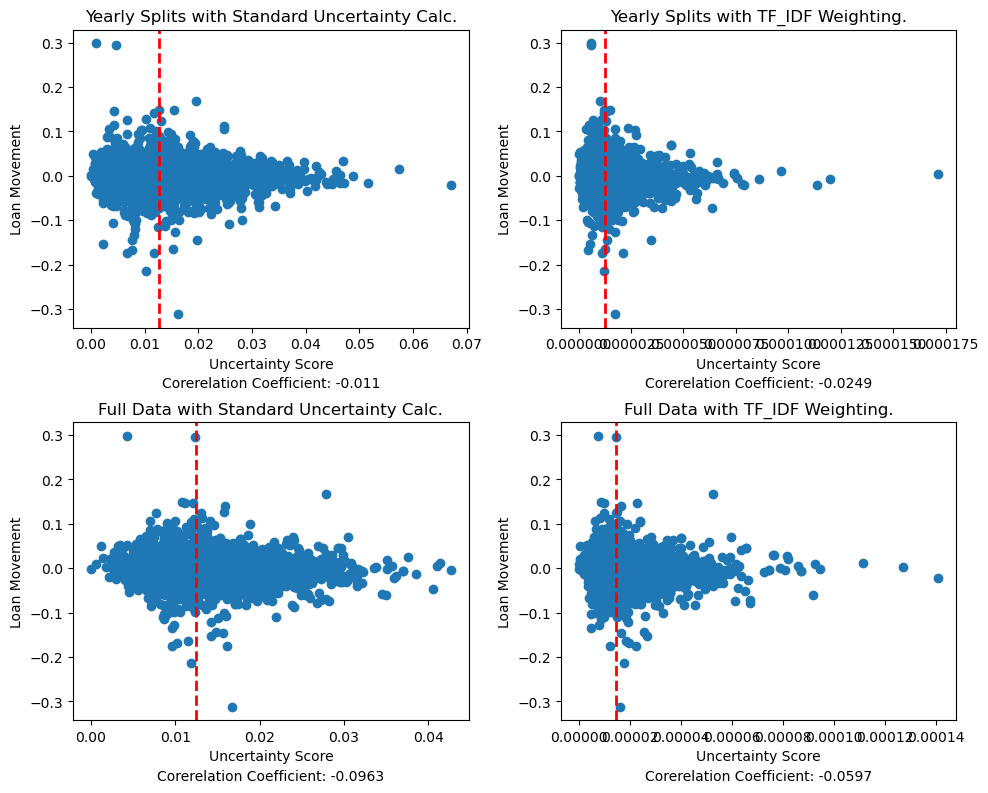

In [28]:
# Scatter plot of uncertainty score vs loan movement
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

mean_value = delta_df['yearnode_uncty_reg'].mean()
correlation = delta_df['yearnode_uncty_reg'].corr(delta_df['l2a_delta'])
axs[0,0].scatter( delta_df['yearnode_uncty_reg'],delta_df['l2a_delta'])
axs[0,0].set_xlabel('Uncertainty Score')
axs[0,0].set_ylabel('Loan Movement')
axs[0,0].set_title('Yearly Splits with Standard Uncertainty Calc.')
axs[0,0].text(0.5, -0.2, 'Corerelation Coefficient: '+str(round(correlation, 4)), ha='center', transform=axs[0, 0].transAxes)
axs[0,0].axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')

mean_value = delta_df['yearnode_uncty_soto'].mean()
correlation = delta_df['yearnode_uncty_soto'].corr(delta_df['l2a_delta'])
axs[0,1].scatter( delta_df['yearnode_uncty_soto'],delta_df['l2a_delta'])
axs[0,1].set_xlabel('Uncertainty Score')
axs[0,1].set_ylabel('Loan Movement')
axs[0,1].set_title('Yearly Splits with TF_IDF Weighting.')
axs[0,1].text(0.5, -0.2, 'Corerelation Coefficient: '+str(round(correlation, 4)), ha='center', transform=axs[0, 1].transAxes)
axs[0,1].axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')

mean_value = delta_df['fullnode_uncty_reg'].mean()
correlation = delta_df['fullnode_uncty_reg'].corr(delta_df['l2a_delta'])
axs[1,0].scatter( delta_df['fullnode_uncty_reg'],delta_df['l2a_delta'])
axs[1,0].set_xlabel('Uncertainty Score')
axs[1,0].set_ylabel('Loan Movement')
axs[1,0].set_title('Full Data with Standard Uncertainty Calc.')
axs[1,0].text(0.5, -0.2, 'Corerelation Coefficient: '+str(round(correlation, 4)), ha='center', transform=axs[1, 0].transAxes)
axs[1,0].axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')

mean_value = delta_df['fullnode_uncty_soto'].mean()
correlation = delta_df['fullnode_uncty_soto'].corr(delta_df['l2a_delta'])
axs[1,1].scatter( delta_df['fullnode_uncty_soto'],delta_df['l2a_delta'])
axs[1,1].set_xlabel('Uncertainty Score')
axs[1,1].set_ylabel('Loan Movement')
axs[1,1].set_title('Full Data with TF_IDF Weighting.')
axs[1,1].text(0.5, -0.2, 'Corerelation Coefficient: '+str(round(correlation, 4)), ha='center', transform=axs[1, 1].transAxes)
axs[1,1].axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')

plt.tight_layout()
plt.show()

In [29]:
# mean_value = delta_df['fullnode_uncty_soto_wl'].mean()
# correlation = delta_df['fullnode_uncty_soto_wl'].corr(delta_df['l2a_delta'])
# plt.scatter( delta_df['fullnode_uncty_soto_wl'],delta_df['l2a_delta'])
# plt.xlabel('Uncertainty Score')
# plt.ylabel('Loan Movement')
# plt.title('Soto Word List with TF-IDF Weighting')
# plt.text(0.5, -0.2, 'Corerelation Coefficient: '+str(round(correlation, 4)), ha='center', transform=plt.gca().transAxes)
# plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
# plt.show()


In [30]:
negative_count = (delta_df['loan_diff'] < 0).sum()
total = len(delta_df)

print(negative_count)
print(negative_count/total)
print(len(delta_df))
print((delta_df['l2a_delta'] < 0).sum())
print((delta_df['l2a_delta']).mean())
print((delta_df['l2a_delta']).var())
print(delta_df['l2a_delta'].abs().var())

2367
0.29146656815663097
8121
3782
1.1268100504988244e-05
0.0004920126113632602
0.0002855916722567654


In [31]:
top_10_rows = delta_df.nlargest(10, 'yearnode_uncty_soto')
print(tabulate(top_10_rows.sort_values(by='yearnode_uncty_soto', ascending=False), headers='keys', tablefmt='pretty'))


+------+---------------+-------------+-----------+---------+--------+--------------------+-------------------+-------------+------------+--------------+-----------+----------------------+----------------------+------------------------+------------------------+
|      | transcript_id |   ciq_id    |  snl_id   | quarter |  year  | total_asset_before | total_asset_after | loan_before | loan_after |  l2a_delta   | loan_diff |  yearnode_uncty_reg  |  fullnode_uncty_reg  |  yearnode_uncty_soto   |  fullnode_uncty_soto   |
+------+---------------+-------------+-----------+---------+--------+--------------------+-------------------+-------------+------------+--------------+-----------+----------------------+----------------------+------------------------+------------------------+
| 1322 |   805134.0    |  885561.0   | 4044758.0 | Q1 2015 | 2015.0 |     1443369.0      |     1439738.0     |  1165214.0  | 1167477.0  | 0.003607782  |  2263.0   | 0.032454361054766734 | 0.028397565922920892 | 0.0001

In [32]:
transcript_id = 963616
year_value = delta_df.loc[delta_df['transcript_id'] == transcript_id, 'year'].values[0]


for word in Nodes.node_dict[year_value].uncertainty_wordlist:
    flat_list = list(itertools.chain.from_iterable(Nodes.node_dict[year_value].bigram_dict[transcript_id]))
    if word in flat_list:
        print(f'{word}')



quarter-to-quarter
concern
volatility
challenge


In [33]:
transcript_lookup('platinum', 2019, Nodes.node_dict)




AttributeError: 'int' object has no attribute 'items'

In [ ]:
import pickle

with open('lemmatized_yearly_.pkl', 'wb') as f:
    pickle.dump(Nodes.node_dict, f)

with open('lemmatized_full_data.pkl', 'wb') as f:
    pickle.dump(full_node, f)


print("Dictionary saved'")

In [89]:
delta_df.to_csv('no_lemmatization_uncertainty_export1.csv')